# AWS + Spark: Exploration of NOAA Weather Data

This notebook demonstrates how to format and plot data with the *leaflet* class, which uses ipyleaflet for data visualization on an interactive map.

## Import libraries.
The main utilities are the *leaflet* class which plots data and some functions for pulling data from the S3 bucket.
The utilities library also contains other functions that the professor uses throughout the notebooks, but they are not necessarily used here

In [1]:
import os.path as path
import sys
import numpy as np
from pyspark import SparkContext, SparkConf
from lib import *
from pyspark.sql import *
from utils import *

import findspark
findspark.init()

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'mean', 'Rectangle', 'Polygon', 'Circle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Create new SparkContext

Set path for the data directory (you will need to manually create ../DataHW3 if it doesn't already exist)

In [2]:
# Create a new spark and sql context
sc = create_sc(pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])
sqlContext = SQLContext(sc)

# Create the names of the files/directories we're working with

data_dir = '../DataHW3'


dict_items([('spark.app.name', 'Weather_PCA'), ('spark.executor.memory', '3g'), ('spark.executor.cores', '1'), ('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.logConf', 'True')])


## Check if we've already downloaded this file

If we have not, we'll need to grab it from the course's S3 bucket

Here are the states that we will look at: <br>
**Northern plains**: North Dakota, South Dakota, Minnesota, Iowa, Nebraska
<br>**Southern plains**: Texas, Oklahoma, Kansas

In [3]:
data_dir = '../DataHW3'

if not path.exists(data_dir + '/' + 'stations.parquet'):
    getStations()

    
states = ['ND', 'SD', 'MN', 'IA', 'NE', 'TX', 'OK', 'KS']

for s in states:
    
    parquet = s + '.parquet'
    tarname = s + '.tgz'
    
    if not path.exists(data_dir + '/' + parquet):

        # pull the weather data for a particular state from the MAS-DSE S3 bucket
        getStateData(s, data_dir, tarname, parquet)


## Create a SQL context for our data

... and perform some sample queries to see what our data looks like

In [4]:
# perform some sample queries to see what our data looks like

state = 'ND'
tarname = state + '.tgz'
parquet = state + '.parquet'
parquet_path = data_dir + '/' + parquet

stations_df = sqlContext.read.parquet(data_dir+'/stations.parquet')
sqlContext.registerDataFrameAsTable(stations_df, 'stations_table')


# create the sparksql context
df = sqlContext.read.parquet(parquet_path)
sqlContext.registerDataFrameAsTable(df,'table')




# Number of stations in ND that have measurement
Query="""
SELECT COUNT(*) 
FROM stations_table
WHERE STATE=='ND'
"""
counts=sqlContext.sql(Query)
counts.show()

# First 5 measurements from the weather table. Note that it looks like 1 measurement is really = 1 year of measurements for that measurement type
Query = """
SELECT *
FROM table
LIMIT 5
"""
all_features = sqlContext.sql(Query)
all_features.show()

# Show the ND stations with the top number of measurements
Query = """
SELECT Station, name, COUNT(Measurement)
FROM table
GROUP BY Station, name
ORDER BY COUNT(Measurement) DESC
"""
weather_query = sqlContext.sql(Query)
weather_query.show()

+--------+
|count(1)|
+--------+
|     180|
+--------+

+-----------+-----------+----+--------------------+------------------+------------------+------------------+-----------------+-----+-------------+
|    Station|Measurement|Year|              Values|        dist_coast|          latitude|         longitude|        elevation|state|         name|
+-----------+-----------+----+--------------------+------------------+------------------+------------------+-----------------+-----+-------------+
|USC00325818|   SNOW_s20|1951|[00 00 00 00 00 0...|1303.8299560546875|47.233299255371094|-103.5999984741211|688.7999877929688|   ND|MEDORA 22 NNW|
|USC00325818|   SNOW_s20|1952|[2B 3D 7B 3D CF 3...|1303.8299560546875|47.233299255371094|-103.5999984741211|688.7999877929688|   ND|MEDORA 22 NNW|
|USC00325818|   SNOW_s20|1953|[0E 40 1B 40 27 4...|1303.8299560546875|47.233299255371094|-103.5999984741211|688.7999877929688|   ND|MEDORA 22 NNW|
|USC00325818|   SNOW_s20|1954|[00 00 00 00 00 0...|1303.829956

In [5]:
# Query = """
# SELECT Station, Measurement, COUNT(Measurement), Values
# FROM table
# WHERE Measurement=='SNWD'
# GROUP BY Station, Measurement, Values
# ORDER BY COUNT(Measurement) DESC
# LIMIT 5
# """
# weather_query = sqlContext.sql(Query)
# weather_query.show()
# test5 = weather_query

Here is an example of reducing the Values feature to a single value using a UDF (user defined function) from utilities

In [6]:
# This is the query that get's performed inside leaflet class, but Values have been cleaned
df = sqlContext.read.parquet(parquet_path)
sqlContext.registerDataFrameAsTable(df,'table')
Query = """
SELECT Station, Measurement, Values, longitude, latitude
FROM table
WHERE Measurement=='SNWD'
LIMIT 5
"""
weather_query = sqlContext.sql(Query)

rdd3 = weather_query.rdd.map(lambda x: replaceSNWD(x, 'Values'))
df2 = sqlContext.createDataFrame(rdd3)
df2.show()

/usr/local/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+-----------+-----------+------------------+-----------------+-----------------+
|Measurement|    Station|            Values|         latitude|        longitude|
+-----------+-----------+------------------+-----------------+-----------------+
|       SNWD|USC00326158|             126.0|46.39310073852539|-102.318603515625|
|       SNWD|USC00326158|108.33333333333333|46.39310073852539|-102.318603515625|
|       SNWD|USC00326158|              99.4|46.39310073852539|-102.318603515625|
|       SNWD|USC00326158| 92.46666666666667|46.39310073852539|-102.318603515625|
|       SNWD|USC00326158|             126.0|46.39310073852539|-102.318603515625|
+-----------+-----------+------------------+-----------------+-----------------+



# Data visualization

Depending on how many states' data we are plotting this could take a little while. The northern and souther plains combined took around ~5 min. 

Nevertheless, we can see the average snow depth during the first three calendar months of the year for these states. 

Note: I only included "ND" and "SD" for demonstration purposes, but it works with all of the states

First initialize the leaflet with sqlContext, and the feature represented as a string.
Then proceed to add states data to the leaflet class by the .add(dataframe) method. **The dataframe should have the format of the query below**.
Once everything has been added, you can run plot_all(). This is the step that will take a while for longer data sets
To show the map, run plotter.m, and to show the legend, run plotter.color_legend()

In [7]:
featureStr = "\'SNWD\'"

plotter = leaflet(sqlContext, featureStr)

# create the sparksql context
for s in ["ND", 'SD']:
    parquet = s + '.parquet'
    parquet_path = data_dir + '/' + parquet
    df = sqlContext.read.parquet(parquet_path)
    sqlContext.registerDataFrameAsTable(df,f'table_{s}')
    
    Query = f"""
    SELECT Station, Measurement, Values, longitude, latitude
    FROM table_{s}
    WHERE Measurement=={featureStr}
    """
    weather_query = sqlContext.sql(Query)
    rdd2 = weather_query.rdd.map(lambda x: replaceSNWD(x, 'Values'))
    df2 = sqlContext.createDataFrame(rdd2)
    
    
    plotter.add(df2)

/usr/local/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [8]:
plotter.plot_all()
plotter.m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[45.88125038146973, -100.28345108032227], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Circle(color='#AAA', fill_color='#ff1a00', fill_opacity=0.4, location=[47.5088996887207, -99.12110137939453], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=8138, weight=1), Circle(color='#AAA', fill_color='#ff6400', fill_opacity=0.4, location=[48.400001525878906, -97.75], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=11192, weight=1), Circle(color='#AAA', fill_color='#baff3c', fill_opacity=0.4, location=[46.627498626708984, -99.13829803466797], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=8899, weight=1), Circle(color='#AAA', fill_color='#ffc400', fill_opacity=0.4, location=[47.11669921875, -99.5333023071289], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=10182, weight=1), Circle(color='#AAA', fill_color='#ffc100', fill_opacity=0.4, location=[47.76190185546875, -98.18170166015625], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=8818, weight=1), Circle(color='#AAA', fill_color='#ff6400', fill_opacity=0.4, location=[46.9557991027832, -98.02030181884766], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=11572, weight=1), Circle(color='#AAA', fill_color='#beff39', fill_opacity=0.4, location=[46.833900451660156, -100.7968978881836], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=3174, weight=1), Circle(color='#AAA', fill_color='#ff9100', fill_opacity=0.4, location=[47.80830001831055, -99.87580108642578], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=9674, weight=1), Circle(color='#AAA', fill_color='#ceff29', fill_opacity=0.4, location=[47.349998474121094, -100.0167007446289], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=7299, weight=1), Circle(color='#AAA', fill_color='#ff7300', fill_opacity=0.4, location=[48.76219940185547, -98.3447036743164], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=12470, weight=1), Circle(color='#AAA', fill_color='#caff2c', fill_opacity=0.4, location=[46.29999923706055, -98.94999694824219], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=4489, weight=1), Circle(co

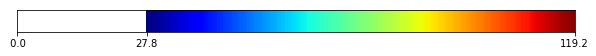

In [9]:
plotter.color_legend()